# Initialization and Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
#to see gpu configuration
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May  7 20:35:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |   3824MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
#training set lagbe na bro
del X_train
del X_train_orig, X_test_orig

In [ ]:
# We split testing set into two halfs.
# S: secret image
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

# Baluja

### Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    x = input_S

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    x = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs= reveal_input,   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C]) #changed
    output_Sprime = decoder(output_Cprime) #changed

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/baluja/baluja_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/baluja/baluja_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/baluja/baluja_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C])

CPU times: user 6.77 s, sys: 4.22 s, total: 11 s
Wall time: 9.76 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C])

CPU times: user 4.52 s, sys: 2.57 s, total: 7.09 s
Wall time: 6.31 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime])

CPU times: user 1.38 s, sys: 209 ms, total: 1.59 s
Wall time: 4.29 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 8.297376
C error per pixel [0, 255]: 8.593446


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

#S error ssim: 0.94013995
#C error ssim: 0.90575194

S error ssim: 0.9402909
C error ssim: 0.9048191


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 30.260637
C error psnr: 29.719843


# Key Concatenation

### Model Implementation







In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = rev_loss(s_true, s_pred)
    c_loss = rev_loss(c_true, c_pred)
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(input_size))

    # input_K = Input(shape=(81,)) #changed
    # filter = Reshape((3, 3, 3, 3))(input_K)
    # x = tf.nn.conv2d(input_S, filter, strides = (1, 1, 1, 1), padding='VALID')


    #x = tf.math.multiply(input_S, input_K)
    x = concatenate([input_S, input_K])
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(input_size))


    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(input_size))  #changed

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
input_K = np.random.randint(256, size=(len(input_S), 64, 64, 3))
input_K = input_K/255.

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation/key_concatenation_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K])

CPU times: user 7.68 s, sys: 4.39 s, total: 12.1 s
Wall time: 10.8 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K])

CPU times: user 4.75 s, sys: 2.62 s, total: 7.37 s
Wall time: 6.48 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K])

CPU times: user 3.33 s, sys: 1.81 s, total: 5.14 s
Wall time: 4.52 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 5.7310534
C error per pixel [0, 255]: 7.2865224


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.96616524
C error ssim: 0.9189242


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 33.398727
C error psnr: 31.175766


### Wrong Key

In [ ]:
wrong_input_K = np.random.randint(256, size=(len(input_S), 64, 64, 3))
wrong_input_K = wrong_input_K/255.

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K])

In [ ]:
arr_position = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


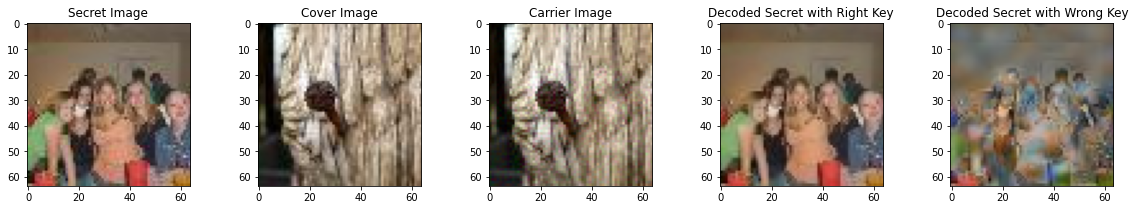

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()

# Pixel Shuffling

### Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(12288,))

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 12288])
    indices = tf.stack([i1, integer_K], axis=-1)
    tensor = Flatten()(input_S)
    shape = tf.shape(tensor)
    scattered_tensor = tf.scatter_nd(indices, tensor, shape)
    x = Reshape((64,64,3))(scattered_tensor)


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(12288,))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = input_with_noise
    # tensor = Flatten()(x)
    # #tensor = Reshape((1, -1))(tensor)
    # print(tensor.shape)
    # indices = Reshape((-1,2))(input_K)
    # indices = tf.dtypes.cast(indices, tf.int32)
    # print(indices.shape)
    # shape = tf.shape(tensor)

    # scattered_tensor = tf.gather_nd(tensor, indices)
    # x = Reshape((64,64,3))(scattered_tensor)
    # print(x.shape)

    #x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 12288])
    indices = tf.stack([i1,integer_K], axis=-1)
    tensor = Flatten()(x)
    shape = tf.shape(tensor)

    scattered_tensor = tf.gather_nd(tensor, indices)
    output_Sprime= Reshape((64,64,3))(scattered_tensor)
    #print(x.shape)

    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(12288,))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
input_K = np.zeros(shape=(len(input_S), 12288))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, 12288), 12288)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/pixel_shuffling/pixel_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/pixel_shuffling/pixel_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/pixel_shuffling/pixel_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K])

CPU times: user 9.56 s, sys: 3.98 s, total: 13.5 s
Wall time: 11.4 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K])

CPU times: user 6.5 s, sys: 2.48 s, total: 8.98 s
Wall time: 7.29 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K])

CPU times: user 3.89 s, sys: 275 ms, total: 4.17 s
Wall time: 5.59 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 50.89592
C error per pixel [0, 255]: 14.030267


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.30657724
C error ssim: 0.89167595


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 14.419726
C error psnr: 25.985256


### Wrong Key

In [ ]:
wrong_input_K = np.zeros(shape=(len(input_S), 12288))
for i in range(len(input_S)):
    wrong_input_K[i] = random.sample(range(0, 12288), 12288)

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K])

In [ ]:
arr_position = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


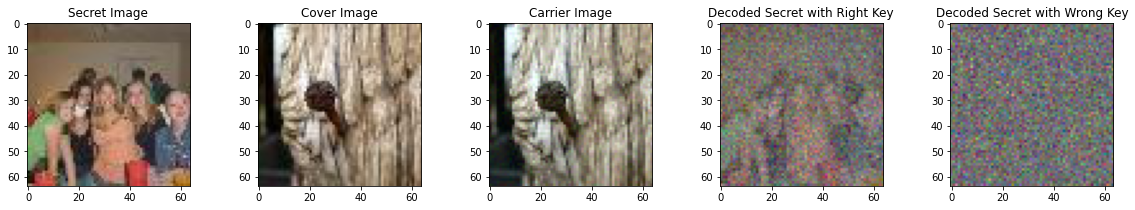

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()

# One Block Shuffling

### Model Implementation


In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(4096,))

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 4096])
    indices = tf.stack([i1, integer_K], axis=-1)
    tensor = Reshape(( -1, 3))(input_S)
    shape = tf.shape(tensor)
    scattered_tensor = tf.scatter_nd(indices, tensor, shape)
    x = Reshape((64,64,3))(scattered_tensor)


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(4096,))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = input_with_noise

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 4096])
    indices = tf.stack([i1,integer_K], axis=-1)
    tensor = Reshape(( -1, 3))(x)
    shape = tf.shape(tensor)

    scattered_tensor = tf.gather_nd(tensor, indices)
    output_Sprime= Reshape((64,64,3))(scattered_tensor)
    #print(x.shape)

    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(4096,))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
input_K = np.zeros(shape=(len(input_S), 4096))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, 4096), 4096)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K])

CPU times: user 8.36 s, sys: 4.38 s, total: 12.7 s
Wall time: 11.1 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K])

CPU times: user 5.44 s, sys: 2.52 s, total: 7.96 s
Wall time: 6.8 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K])

CPU times: user 2.97 s, sys: 720 ms, total: 3.69 s
Wall time: 4.76 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 10.334786
C error per pixel [0, 255]: 10.894108


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.9178323
C error ssim: 0.8586297


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 28.808044
C error psnr: 27.678288


### Wrong Key

In [ ]:
wrong_input_K = np.zeros(shape=(len(input_S), 4096))
for i in range(len(input_S)):
    wrong_input_K[i] = random.sample(range(0, 4096), 4096)

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K])

In [ ]:
arr_position = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


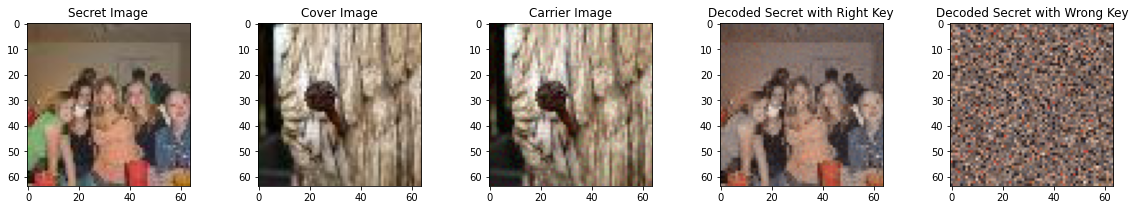

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()

# Eight Block Shuffling

### Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K= Input(shape=(total_block,))

    batch_size = tf.shape(input_S)[0]
    # print(tf.shape(input_S))
    # block_in_one_axis =  row // block_size
    # total_block = block_in_one_axis * block_in_one_axis


    blocks = tf.image.extract_patches(input_S,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size, total_block, block_size, block_size, 3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    scattered = tf.scatter_nd(indices, blocks, (batch_size, total_block, block_size, block_size,3 ))

    scattered_blocks = tf.unstack(scattered, axis =1)
    scattered_tensor_row_wise = [tf.concat(scattered_blocks[i:i+block_in_one_axis], axis = -2) for i in tf.range(0,total_block,block_in_one_axis)]
    x = tf.keras.layers.concatenate(scattered_tensor_row_wise, axis = 1)


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K], #changed
                  outputs=output_Cprime,
                  name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    reveal_input = Input(shape=(input_size))

    batch_size = tf.shape(reveal_input)[0]
    # print(tf.shape(reveal_input))
    # block_in_one_axis =  row // block_size
    # total_block = block_in_one_axis * block_in_one_axis

    input_K= Input(shape=(total_block,))


    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = input_with_noise

    #x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)


    scattered_tensor = x
    blocks = tf.image.extract_patches(scattered_tensor,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size,total_block,block_size,block_size,3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)

    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    unscattered = tf.gather_nd(blocks,indices)

    unscattered_blocks = tf.unstack(unscattered, axis =1)
    unscattered_tensor_row_wise = [tf.concat(unscattered_blocks[i:i+block_in_one_axis], axis = -2) for i in range(0,total_block,block_in_one_axis)]
    output_Sprime = tf.keras.layers.concatenate(unscattered_tensor_row_wise, axis = 1)

    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(total_block,))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
# Block size to fragment the image
block_size = 8
block_in_one_axis =  64 // block_size
total_block = block_in_one_axis * block_in_one_axis

In [ ]:
input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, total_block), total_block)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/eight_block_shuffling/eight_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K])

CPU times: user 3.54 s, sys: 511 ms, total: 4.05 s
Wall time: 11.3 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K])

CPU times: user 4.94 s, sys: 2.65 s, total: 7.59 s
Wall time: 6.66 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K])

CPU times: user 1.73 s, sys: 201 ms, total: 1.94 s
Wall time: 4.66 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 7.060246
C error per pixel [0, 255]: 8.468828


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.9461185
C error ssim: 0.89989454


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 31.607418
C error psnr: 29.847254


### Wrong Key

In [ ]:
wrong_input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    wrong_input_K[i] = random.sample(range(0, total_block), total_block)

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K])

In [ ]:
arr_position = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


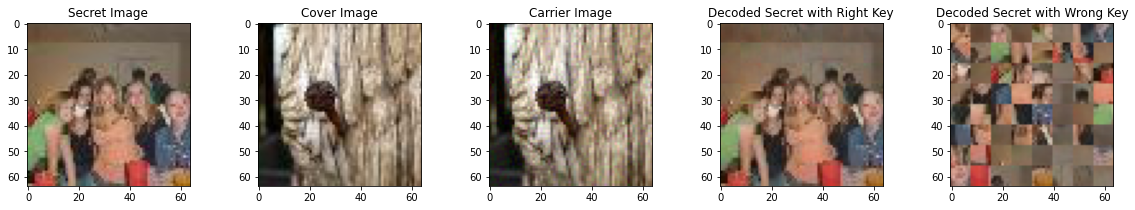

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()

# Key Concatenation + Eight Block Shuffling

### Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size))

    batch_size = tf.shape(input_S)[0]

    blocks = tf.image.extract_patches(input_S,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size, total_block, block_size, block_size, 3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    scattered = tf.scatter_nd(indices, blocks, (batch_size, total_block, block_size, block_size,3 ))

    scattered_blocks = tf.unstack(scattered, axis =1)
    scattered_tensor_row_wise = [tf.concat(scattered_blocks[i:i+block_in_one_axis], axis = -2) for i in tf.range(0,total_block,block_in_one_axis)]
    x = concatenate(scattered_tensor_row_wise, axis = 1)

    # Key Concatenation
    x = concatenate([x, input_K_concat])


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K, input_K_concat], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size))

    batch_size = tf.shape(reveal_input)[0]
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    x = concatenate([input_with_noise, input_K_concat])
    #x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    scattered_tensor = x
    blocks = tf.image.extract_patches(scattered_tensor,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size,total_block,block_size,block_size,3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)

    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    unscattered = tf.gather_nd(blocks,indices)

    unscattered_blocks = tf.unstack(unscattered, axis =1)
    unscattered_tensor_row_wise = [tf.concat(unscattered_blocks[i:i+block_in_one_axis], axis = -2) for i in range(0,total_block,block_in_one_axis)]
    output_Sprime = concatenate(unscattered_tensor_row_wise, axis = 1)


    if not fixed:
        return Model(inputs=[reveal_input,input_K, input_K_concat],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K, input_K_concat],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    # Calculations for dividing into blocks

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(total_block,))
    input_K_concat = Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K, input_K_concat]) #changed
    output_Sprime = decoder([output_Cprime, input_K, input_K_concat]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K, input_K_concat],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
# Calculations for dividing into blocks
block_size = 8
block_in_one_axis =  64 // block_size
total_block = block_in_one_axis * block_in_one_axis

In [ ]:
input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, total_block), total_block)

input_K_concat = np.random.randint(256, size=(len(input_S), 64, 64, 3))
input_K_concat = input_K_concat/255.

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/key_concatenation_eight_block_shuffling/key_concatenation_eight_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K, input_K_concat])

CPU times: user 3.83 s, sys: 447 ms, total: 4.28 s
Wall time: 11.6 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K, input_K_concat])

CPU times: user 5.18 s, sys: 2.63 s, total: 7.81 s
Wall time: 6.82 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K, input_K_concat])

CPU times: user 3.29 s, sys: 1.35 s, total: 4.64 s
Wall time: 4.78 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 8.356113
C error per pixel [0, 255]: 11.432892


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.94564766
C error ssim: 0.8990875


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 29.978703
C error psnr: 27.86518


### Wrong Key

In [ ]:
wrong_input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    wrong_input_K[i] = random.sample(range(0, total_block), total_block)

wrong_input_K_concat = np.random.randint(256, size=(len(input_S), 64, 64, 3))
wrong_input_K_concat = wrong_input_K_concat/255.

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K, wrong_input_K_concat])

In [ ]:
arr_position = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


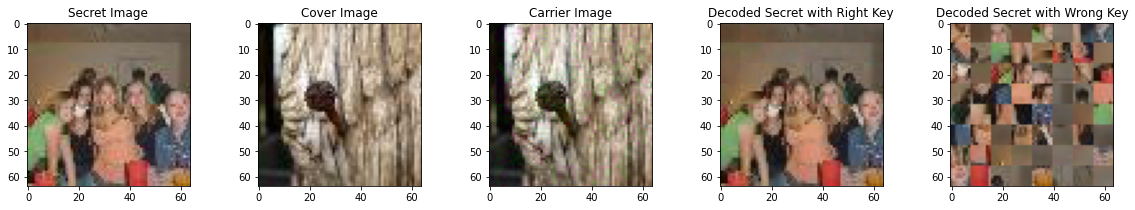

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()

# Four Block Shuffling

### Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0

# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K= Input(shape=(total_block,))

    batch_size = tf.shape(input_S)[0]
    # print(tf.shape(input_S))
    # block_in_one_axis =  row // block_size
    # total_block = block_in_one_axis * block_in_one_axis


    blocks = tf.image.extract_patches(input_S,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size, total_block, block_size, block_size, 3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    scattered = tf.scatter_nd(indices, blocks, (batch_size, total_block, block_size, block_size,3 ))

    scattered_blocks = tf.unstack(scattered, axis =1)
    scattered_tensor_row_wise = [tf.concat(scattered_blocks[i:i+block_in_one_axis], axis = -2) for i in tf.range(0,total_block,block_in_one_axis)]
    x = tf.keras.layers.concatenate(scattered_tensor_row_wise, axis = 1)


    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C, input_K], #changed
                  outputs=output_Cprime,
                  name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    reveal_input = Input(shape=(input_size))

    batch_size = tf.shape(reveal_input)[0]
    # print(tf.shape(reveal_input))
    # block_in_one_axis =  row // block_size
    # total_block = block_in_one_axis * block_in_one_axis

    input_K= Input(shape=(total_block,))


    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = input_with_noise

    #x = concatenate([input_with_noise, input_K])
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)


    scattered_tensor = x
    blocks = tf.image.extract_patches(scattered_tensor,sizes=[1,block_size,block_size,1],strides=[1,block_size,block_size,1],rates=[1, 1, 1, 1],padding='VALID')
    blocks = tf.reshape(blocks,[batch_size,total_block,block_size,block_size,3])

    integer_K = tf.dtypes.cast(input_K, tf.int32)

    i1 = tf.expand_dims(tf.range(batch_size), axis = 1)
    i1 = tf.tile(i1, [1, total_block])
    indices = tf.stack([i1,integer_K], axis=-1)

    unscattered = tf.gather_nd(blocks,indices)

    unscattered_blocks = tf.unstack(unscattered, axis =1)
    unscattered_tensor_row_wise = [tf.concat(unscattered_blocks[i:i+block_in_one_axis], axis = -2) for i in range(0,total_block,block_in_one_axis)]
    output_Sprime = tf.keras.layers.concatenate(unscattered_tensor_row_wise, axis = 1)

    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):

    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(total_block,))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

## Test

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
# Block size to fragment the image
block_size = 4
block_in_one_axis =  64 // block_size
total_block = block_in_one_axis * block_in_one_axis

In [ ]:
input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, total_block), total_block)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/four_block_shuffling/four_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/four_block_shuffling/four_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/four_block_shuffling/four_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def ssim(input_S, input_C, decoded_S, decoded_C):
  ssim_S = tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))
  ssim_C = tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

  return ssim_S.numpy(), ssim_C.numpy()

In [ ]:
def psnr(input_S, input_C, decoded_S, decoded_C):
  psnr_S = tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))
  psnr_C = tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

  return psnr_S.numpy(), psnr_C.numpy()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return rmse_Spixel, rmse_Cpixel

### Total prediction time

In [ ]:
%%time
decoded = autoencoder_model.predict([input_S, input_C, input_K])

CPU times: user 4.17 s, sys: 515 ms, total: 4.68 s
Wall time: 11.4 s


In [ ]:
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

### Encryption time

In [ ]:
%%time
C_prime = encoder_model.predict([input_S, input_C, input_K])

CPU times: user 5.4 s, sys: 2.49 s, total: 7.89 s
Wall time: 6.94 s


### Decryption time

In [ ]:
%%time
S_prime = reveal_model.predict([C_prime, input_K])

CPU times: user 2.17 s, sys: 243 ms, total: 2.42 s
Wall time: 4.75 s


### Pixel error

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 5.71092
C error per pixel [0, 255]: 8.898326


### SSIM

In [ ]:
S_error, C_error = ssim(input_S, input_C, decoded_S, decoded_C)

print ("S error ssim:", S_error)
print ("C error ssim:", C_error)

S error ssim: 0.9609343
C error ssim: 0.8911334


### PSNR

In [ ]:
S_error, C_error = psnr(input_S, input_C, decoded_S, decoded_C)

print ("S error psnr:", S_error)
print ("C error psnr:", C_error)

S error psnr: 33.53377
C error psnr: 29.381697


### Wrong Key

In [ ]:
wrong_input_K = np.zeros(shape=(len(input_S), total_block))
for i in range(len(input_S)):
    wrong_input_K[i] = random.sample(range(0, total_block), total_block)

In [ ]:
wrong_S_prime = reveal_model.predict([C_prime, wrong_input_K])

In [ ]:
arr_position = 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


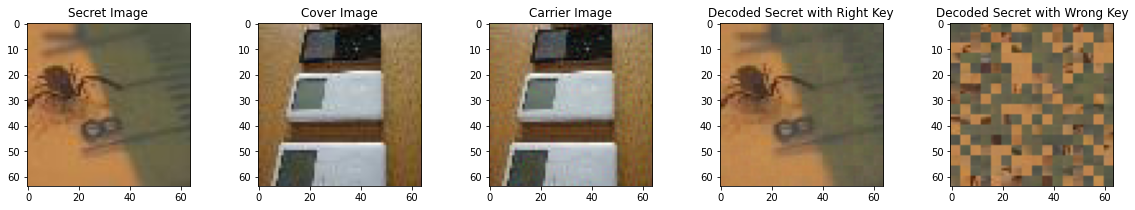

In [ ]:
fig, a = plt.subplots(1, 5, figsize=(20, 3))
a[0].imshow(input_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(input_C[arr_position])
a[1].set_title('Cover Image')
a[2].imshow(C_prime[arr_position])
a[2].set_title('Carrier Image')
a[3].imshow(S_prime[arr_position])
a[3].set_title('Decoded Secret with Right Key')
a[4].imshow(wrong_S_prime[arr_position])
a[4].set_title('Decoded Secret with Wrong Key')
plt.show()